#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite Volume methods for hyperoblic conservation laws

Hyperbolic conservation laws have the form

$$ u_t + \nabla\cdot f(u) = 0 $$

where the (possibly nonlinear) function $f(u)$ is called the **flux**.  If $u$ has $m$ components, $f(u)$ is an $m\times d$ matrix in $d$ dimensions.  We can express finite volume methods by choosing test functions $v(x)$ that are piecewise constant on each element $e$ and integrating by parts
\begin{split} \int_\Omega v u_t + v \nabla\cdot f(u) = 0 \text{ for all } v \\
 \left( \int_e u \right)_t + \int_{\partial e} f(u) \cdot \hat n = 0 \text{ for all } e .
\end{split}
In finite volume methods, we choose as our unknowns the average values $\bar u$ on each element, leading to the discrete equation
$$ \lvert e \rvert \bar u_t + \int_{\partial e} f(u) \cdot \hat n = 0 \text{ for all } e $$
where $\lvert e \rvert$ is the volume of element $e$.
The most basic methods will compute the interface flux in the second term using the cell average $\bar u$, though higher order methods will perform a reconstruction using neighbors.
Since $\bar u$ is discontinuous at element interfaces, we will need to define a numerical flux using the (possibly reconstructed) value on each side.  First, let's consider some hyperbolic equations.

## Examples in 1D

### Advection
$$ u_t + \nabla\cdot (\underbrace{c u}_{f(u)}) = 0 $$
where $c$ is velocity.  In the absence of boundary conditions, this has the solution
$$ u(t,x) = u(0, x-ct) $$
in terms of the initial condition.  Lines of constant $x-ct$ are called **characteristics**.

### Burger's Equation
$$ u_t + \nabla\cdot (\underbrace{u^2/2}_{f(u)}) = 0 $$
is a model for nonlinear convection.  The wave speed is $f'(u) = u$.

### Traffic

$$ u_t + \nabla\cdot \big(\underbrace{u (1-u)}_{f(u)} \big) = 0 $$
where $u \in [0,1]$ represents density of cars and $1-u$ is their speed.  This is a non-convex flux function.

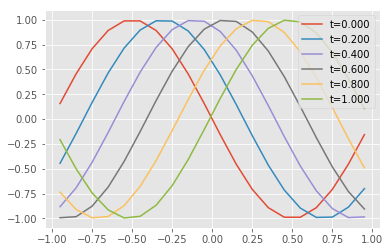

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')
%run fdtools.py

def flux_advection(u):
    return 1*u

def flux_burgers(u):
    return .5*u**2

def flux_traffic(u):
    return u*(1 - u)

def fvsolve0(flux, u0, a=-1, b=1, n=20, tfinal=1):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    idxL = range(-1, n-1)
    def rhs(t, u):
        uL = .5 * (u + u[idxL])
        fluxL = flux(uL)
        div = fluxL.copy()
        div[:-1] -= fluxL[1:]
        div[-1] -= fluxL[0] # Periodic boundary condition
        return div / h
    return x, ode_rkexplicit(rhs, u0(x), h=h, tfinal=tfinal)

def sinpi(x):
    return numpy.sin(-numpy.pi * x)

x, hist = fvsolve0(flux_advection, sinpi)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

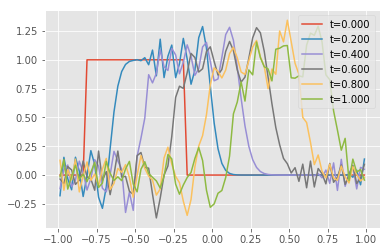

In [2]:
x, hist = fvsolve0(flux_advection,
                   lambda x: (sinpi(x) > .5).astype(float), n=80)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

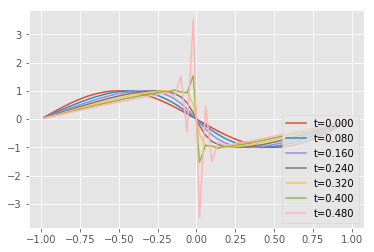

In [3]:
x, hist = fvsolve0(flux_burgers, sinpi, tfinal=.5, n=50)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='lower right');

Evidently our method has problems for discontinuous solutions.

# Shocks, Rarefactions, and Riemann problems

Burger's equation evolved a discontinuity in finite time from a smooth initial condition.  It turns out that all nonlinear hyperbolic equations have this property.  For Burgers, the peak travels to the right, overtaking the troughs.  This is called a **shock** and corresponds to characteristics converging when the gradient of the solution is negative.  When the gradient is positive, the characteristics diverge to produce a **rarefaction**.  The relationship to positive and negative gradients is reversed for a non-convex flux like Traffic.

We need a solution method that can correctly compute fluxes in case of a discontinuous solution.  Finite volume methods represent this in terms of a Riemann problem,
$$ u(0, x) = \begin{cases}
u_L & \text{if} & x < 0 \\
u_R & \text{if} & x > 0
\end{cases}
$$
where $u_L$ and $u_R$ are given.  The solution of a Riemann problem is the solution $u(t, x)$ at positive times.  In our finite volume schemes, it will be sufficient to compute the flux at $x=0$ at an infinitessimal positive time
$$\tilde f(u_L, u_R) = \lim_{t\to 0} f\big(u(t, 0) \big) . $$
We call $\tilde f$ the **numerical flux** and require that it must be consistent when there is no discontinuity,
$$ \tilde f(u, u) = f(u) .$$

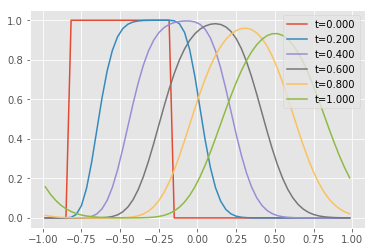

In [4]:
def riemann_advection(uL, uR):
    return 1*uL

def fvsolve1(riemann, u0, a=-1, b=1, n=20, tfinal=1):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    idxL = range(-1, n-1)
    def rhs(t, u):
        fluxL = riemann(u[idxL], u)
        div = fluxL.copy()
        div[:-1] -= fluxL[1:]
        div[-1] -= fluxL[0] # Periodic boundary condition
        return div / h
    return x, ode_rkexplicit(rhs, u0(x), h=h, tfinal=tfinal)

x, hist = fvsolve1(riemann_advection,
                   lambda x: (sinpi(x) > .5).astype(float), n=60)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

## Rankine-Hugoniot condition

For a nonlinear equation, we need to know which direction the shock is moving.  If we move into the reference frame of the shock, the flux on the left must be equal to the flux on the right.  This leads to shock speed $s$ satisfying
$$ s \Delta u = \Delta f \cdot \hat n $$
where $\hat n$ is any direction (e.g., the normal to a face in a multi-dimensional finite volume method).
This condition holds also for hyperbolic systems (where $u$ has multiple components).

For Burger's equation, our Riemann problem produces a shock if $u_L > u_R$, i.e., $\Delta u < 0$.
The shock moves to the right $(s > 0)$ if $\Delta f < 0$, i.e., $f(u_L) > f(u_R)$.

![Toro (2009) Figure 2.13](figures/Toro-Shock-2.13.png)

So if the solution is a shock, the numerical flux is the maximum of $f(u_L)$ and $f(u_R)$.
We still don't know what to do in case of a rarefaction so will just average and see what happens.

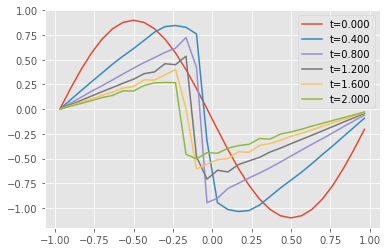

In [5]:
def riemann_burgers_shock(uL, uR):
    return numpy.where(uL > uR,
                       numpy.maximum(flux_burgers(uL), flux_burgers(uR)), # shock
                       flux_burgers(.5*(uL+uR))) # rarefaction

x, hist = fvsolve1(riemann_burgers_shock, lambda x:sinpi(x)-.1, n=30, tfinal=2)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

Much better than before, though we have these odd ripples in the rarefaction.

It turns out that an expansion shock is a **mathematical solution** to the PDE, though such solutions are not physical.

![Toro (2009) Figure 2.14](figures/Toro-ShockRarefaction-2.14.png)

but this violates the **entropy condition**
$$ f'(u_L) > s > f'(u_R) . $$
Shocks are compressive phenomena and physical solutions to the expansive scenario $f'(u_L) < f'(u_R)$ are rarefactions.

![Toro (2009) Figure 2.16](figures/Toro-Rarefaction-2.16.png)

## Entropy functions

Consider a smooth function $\eta(u)$ that is convex $\eta''(u) > 0$ and a smooth solution $u(t,x)$.
Then
$$ u_t + f(u)_x = 0 $$
is equivalent to
$$ u_t + f'(u) u_x = 0 $$
and we can write
$$ \eta'(u) u_t + \eta'(u) f'(u) u_x = 0 . $$
If we find a function $\psi(u)$ such that $\psi'(u) = \eta'(u) f'(u)$, the equation above is equivalent (for smooth solutions) to
$$ \eta(u)_t + \psi(u)_x = 0 $$
which is a conservation law for the entropy $\eta(u)$ with entropy flux $\psi(u)$.

Now consider the parabolic equation
$$ u_t + f(u)_x -\epsilon u_{xx} = 0 $$
for some positive epsilon.  This equation has a smooth solution for any $\epsilon > 0$ and $t > 0$ so we can multpilpy by $\eta'(u)$ as above and apply the chain rule to yield
$$ \eta(u)_t + \psi(u)_x - \epsilon \eta'(u) u_{xx} = 0 . $$
Rearranging the last term produces
$$ \eta(u)_t + \psi(u)_x - \epsilon \Big( \eta'(u) u_x \Big)_x = - \epsilon \eta''(u) u_x^2 . $$
If both terms involving $\epsilon$ were to vanish, we would be left with conservation of entropy.
Now
$$ \int_a^b \Big( \eta'(u) u_x \Big)_x dx = \eta'(u) u_x |_{x=a}^b $$
which is bounded independent of the values $u_x$ may take inside the interval.  Consequently, the left hand side reduces to a conservation law in the limit $\epsilon\to 0$.
The integral of the right hand side, however, does not vanish in the limit since
$$\int_a^b u_x^2$$ is unbounded as $u_x$ grows.
This results in entropy being dissipated across shocks.

#### Mathematical versus physical entropy

Our choice of $\eta(u)$ being a convex function $\eta''(u) > 0$ causes entropy to be dissipated across shocks.  This is a mathematical convention because convex analysis chose this convention.  Physical entropy is produced by such processes, so $-\eta(u)$ would make sense as a physical entropy.

While any convex function will work to show uniqueness for scalar conservation laws, that is not true of hyperbolic systems.  For an actual physical system, entropy is uniquely defined.  For example, the shallow water equations conserve mass and momentum, but energy is only conserved for smooth solutions -- shocks produce heat which is not a conserved variable.

## Looking into the rarefaction fan



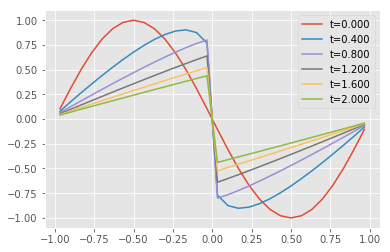

In [6]:
def riemann_burgers(uL, uR):
    return numpy.where(uL > uR,
                       numpy.maximum(flux_burgers(uL), flux_burgers(uR)), # shock
                       numpy.where(uL > 0,
                                   flux_burgers(uL),                # rarefaction moving to the right
                                   flux_burgers(numpy.minimum(uR,   # rarefaction moving to the left
                                                              0)))) # transonic rarefaction

x, hist = fvsolve1(riemann_burgers, sinpi, n=30, tfinal=2)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

### Traffic

Our flux function is
$$ f(u) = u (1 - u) $$
and corresponding wave speed is
$$ f'(u) = 1 - 2 u . $$
The entropy condition for a shock is
$$ f'(u_L) > f'(u_R) $$
which occurs whenever $u_L < u_R$.
According to Rankine-Hugoniot
$$ s \Delta u = \Delta f, $$
the shock moves to the right when $\Delta f = f(u_R) - f(u_L)$ is positive.
A rarefaction occurs when $u_L > u_R$ and moves to the right when $f'(u_L) > 0$ which is the case when $u_L < 0.5$.

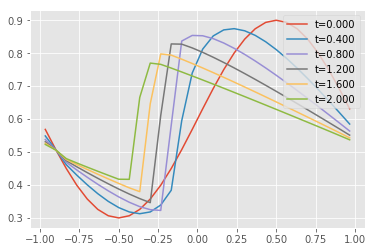

In [7]:
def riemann_traffic(uL, uR):
    return numpy.where(uL < uR,
                       numpy.minimum(flux_traffic(uL), flux_traffic(uR)), # shock
                       numpy.where(uL < .5,
                                   flux_traffic(uL),                # rarefaction moving to the right
                                   flux_traffic(numpy.maximum(uR,   # rarefaction moving to the left
                                                              .5)))) # transonic rarefaction

x, hist = fvsolve1(riemann_traffic, lambda x: .6-.3*sinpi(x), n=30, tfinal=2)
for t, u in hist[::len(hist)//5]:
    pyplot.plot(x, u, label='t={:.3f}'.format(t))
pyplot.legend(loc='upper right');

# Higher order methods

First, a barrier.

### Godunov's Theorem (1954)

Linear numerical methods
$$ \dot u_i = \sum_j a_{ij} u_j $$
for solving time-dependent PDE that are monotone can be at most first order accurate.
For our purposes, monotonicity is equivalent to positivity preservation,
$$ \min_x u(0, x) \ge 0 \quad \Longrightarrow \quad \min_x u(t, 0) \ge 0 .$$

### Discontinuities

A numerical method for representing a discontinuous function on a stationary grid can be no better than first order accurate in the $L^1$ norm,
$$ \lVert u - u^* \rVert_{L^1} = \int \lvert u - u^* \rvert . $$
If we merely sample a discontinuous function, say
$$ u(x) = \begin{cases} 0, & x \le a \\ 1, & x > a \end{cases} $$
onto a grid with element size $\Delta x$ then we will have errors of order 1 on an interval proportional to $\Delta x$.

In light of these two observations, we may still ask for numerical methods that are more than first order accurate for smooth solutions, but those methods must be nonlinear.

## Slope reconstruction

One method for constructing higher order methods is to use the state in neighboring elements to perform a conservative reconstruction of a piecewise polynomial, then compute numerical fluxes by solving Riemann problems at the interfaces.  If $x_i$ is the center of cell $i$ and $g_i$ is the reconstructed gradient inside cell $i$, our reconstructed solution is
$$ \tilde u_i(x) = u_i + g_i \cdot (x - x_i) . $$
We would like this reconstruction to be monotone in the sense that
$$ \Big(\tilde u_i(x) - \tilde u_j(x) \Big) \Big( u_i - u_j \Big) \ge 0 $$
for any $x$ on the interface between element $i$ and element $j$.

#### Question
Is the symmetric slope
$$ \hat g_i = \frac{u_{i+1} - u_{i-1}}{2 \Delta x} $$
monotone?

We will express gradients by "limiting" the above slope using a nonlinear function that reduces to 1 when the solution is smooth.